In [2]:
import numpy as np
import matplotlib.pyplot as plt
import corner
import emcee
import time
from himmelblau import himmelblau
from rosenbrock import rosenbrock_3d
from stretch_move import stretch_move
import tqdm

# File name
function = "himmelblau"
path = f"results/SM/{function}"

file_name = f"{path}/{function}.txt"

# Log-probability function for MCMC
def log_prob(theta):
    return -himmelblau(theta)

# Initialize parameters
nwalkers = 40
ndim = 2
nsteps = 100000
a = 1.5
p0 = 8 * np.random.rand(nwalkers, ndim) - 4 # Initial grid

# Print initial conditions
#store autput in file
f = open(file_name, "w")
f.write("Comparison costum vs emcee\n")
f.write(f"{function} function\n")
f.write("\n")
f.write("ndim: " + str(ndim) + "\n")
f.write("nwalkers: " + str(nwalkers) + "\n")
f.write("nsteps: " + str(nsteps) + "\n")
f.write("Stretch factor: " + str(a) + "\n")
f.write("Initial positions: " + str(np.min(p0)) + " - " + str(np.max(p0)) + "\n")

# Run the custom MCMC sampler
print("Run costum MCMC sampler")
samples_costum, acceptance_count, delta_t_costum_costum = stretch_move(log_prob, p0, nsteps, nwalkers, ndim, a)

# Calculate the mean acceptance rate
mean_acceptance_rate_costum = acceptance_count / (nsteps * nwalkers)

# Calculate the autocorrelation times
autocorr_times_costum = emcee.autocorr.integrated_time(samples_costum)

# Cut away 5 times the autocorellation time from samples
samples_costum_uncut = samples_costum
samples_costum = samples_costum[5 * int(np.max(autocorr_times_costum)):]

# Print results
f.write("\n")
f.write("Costum implementation \n")
f.write(f"Autocorrelation times for each dimension: {autocorr_times_costum} \n")
f.write(f"Mean acceptance rate: {mean_acceptance_rate_costum} \n")
f.write(f"Runtime for {nsteps}: {delta_t_costum_costum} \n")

# Run the emcee sampler
start_time = time.time()

# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, moves=emcee.moves.StretchMove(a=a))

# Use state as new initial values
print("Run emcee sampler")

sampler.run_mcmc(p0, nsteps, progress=True)
samples_emcee = sampler.get_chain()
end_time = time.time()

delta_t_emcee = end_time - start_time

autocorr_times = emcee.autocorr.integrated_time(samples_emcee)

# Cut away 5 times the autocorrelation time from samples
samples_emcee = samples_emcee[int(5 * np.max(autocorr_times)):]

# Print results for emcee
f.write("\n")
f.write("Costum implementation \n")
f.write(f"Autocorrelation times for each dimension: {autocorr_times} \n")
f.write(f"Mean acceptance rate: {np.mean(sampler.acceptance_fraction)} \n")
f.write(f"Runtime for {nsteps}: {delta_t_emcee} \n")
f.close()

Run costum MCMC sampler


100%|██████████| 100000/100000 [00:59<00:00, 1685.11it/s]


Run emcee sampler


100%|██████████| 100000/100000 [00:52<00:00, 1911.32it/s]


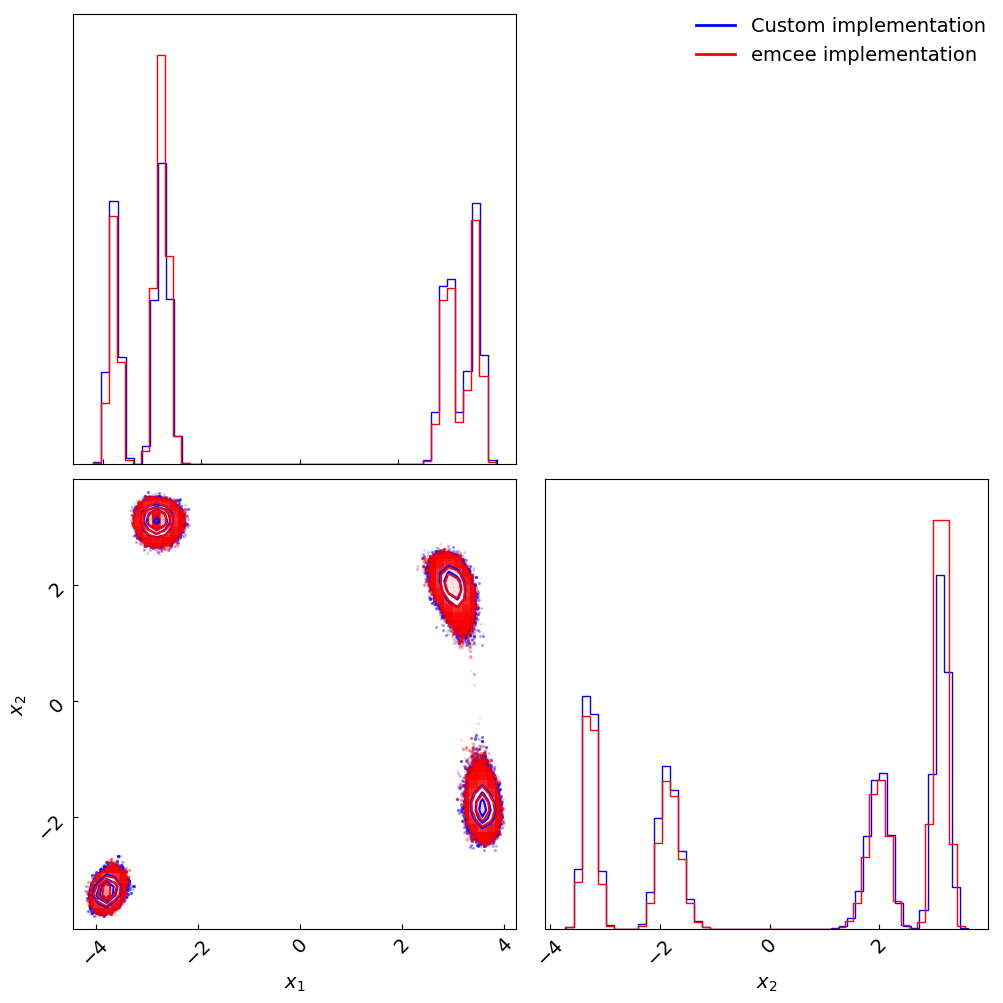

In [25]:
# Create figure and axes
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
corner.corner(samples_costum.reshape(-1, ndim), bins=50, labels=["$x_1$", "$x_2$"], fig=fig, color="blue")
corner.corner(samples_emcee.reshape(-1, ndim), bins=50, labels=["$x_1$", "$x_2$"], fig=fig, color="red")
handles = [plt.Line2D([0], [0], color="blue", lw=2, label="Custom implementation"),
           plt.Line2D([0], [0], color="red", lw=2, label="emcee implementation")]
fig.legend(handles=handles, loc="upper right", frameon=False, fontsize=14)

axes = np.array(fig.axes).reshape((2, 2))

# x-axis
for ax in axes[-1, :]:
    ax.xaxis.label.set_fontsize(14)
    ax.xaxis.label.set_position((0.5, -0.1))
    #ax.tick_params(axis='x', direction='in', labelsize=14)
    
# y-axis
for ax in axes[:, 0]:
    ax.yaxis.label.set_fontsize(14)
    ax.yaxis.label.set_position((-0.1, 0.5))
    #ax.tick_params(axis='y', direction='in', labelsize=14)

for ax in fig.axes:
    ax.tick_params(axis='x', direction='in', labelsize=14)
    ax.tick_params(axis='y', direction='in', labelsize=14)

fig.tight_layout()
fig.savefig(f"{path}/{function}_corner_comparison.pdf")